In [21]:
using Images
using JLD

In [22]:
hfilters = load("filters_learned.jld","filters")
println(size(hfilters))


(24, 3, 3, 4, 9)


In [23]:
hfilters[1,2,1,2,:]

9-element Array{Float64,1}:
  0.109412 
  0.0983984
  0.132599 
 -0.055814 
  0.059723 
  0.209721 
 -0.0273645
  0.102382 
 -0.517856 

In [28]:
using Distributions
INTERPOLATED_FOLDER = "/Users/manvithaponnapati/RAISR/train_data/interpolated/"
low_res_im = load(INTERPOLATED_FOLDER*"15011.jpg")
scale_factor = 2
Qangle = 24
Qstrength = 3
Qcoherence = 3
patchsize = 3

start_index = Int(ceil(patchsize/2))
weights_matrix = rand(Normal(0, 2), patchsize*patchsize)
weights_matrix = Array(Diagonal(weights_matrix))

colorview_rgb = convert(Array{Float64},channelview(low_res_im))
color_ve = 0.21*colorview_rgb[1,:,:]+ 0.72*colorview_rgb[2,:,:]+0.07*colorview_rgb[3,:,:]

w,h = size(color_ve)
predictHR = zeros(w,h)

for row in start_index:Int(w)-start_index
    for col in start_index:Int(h)-start_index
                patch = color_ve[row-1:row+1,col-1:col+1]
                gx,gy = imgradients(patch)
                gx = reshape(gx,patchsize*patchsize,1)
                gy = reshape(gy,patchsize*patchsize,1)
                GT = transpose([gx gy])
                GTWG = GT*weights_matrix*transpose(GT)
                eigen_max = eigmax(GTWG)
                eigen_min = eigmin(GTWG)
                eigen_vector_max = eigvecs(GTWG)[:,1]
                eigen_vector_min = eigvecs(GTWG)[:,2]
                gradient_angle = atan2(eigen_vector_max[2],eigen_vector_max[1])
                if gradient_angle < 0
                    gradient_angle = gradient_angle + pi
                end
                lamda = abs(sqrt(complex(eigen_max)))/Qstrength
                u =(sqrt(complex(eigen_max)) -  sqrt(complex(eigen_min)))/(sqrt(complex(eigen_max)) +  sqrt(complex(eigen_min)))/Qcoherence
                angle = floor(gradient_angle/pi*Qangle)


                if lamda < 0.0001
                    strength = 1
                elseif lamda > 0.001
                    strength = 3
                else
                    strength = 2
                end

                u = abs(u)
                if u < 0.25
                    coherence = 1
                elseif u > 0.5
                    coherence = 3
                else
                    coherence = 2
                end


                # Bound the output to the desired ranges
                if angle > 23
                    angle = 23
                elseif angle <= 0
                    angle = 1
                end
                angle = Int(angle)
                # Get pixel type
                pixeltype = ((row-start_index) % scale_factor) * scale_factor + ((col-start_index) % scale_factor)
                patch_ravel = reshape(patch,patchsize*patchsize)
                predictHR[row,col]=dot(patch_ravel,hfilters[angle,strength,coherence,pixeltype+1,:])
    end
end

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] imgradients(::Array{Float64,2}) at /Users/manvithaponnapati/.julia/v0.6/ImageFiltering/src/specialty.jl:50
 [3] macro expansion at ./In[28]:23 [inlined]
 [4] anonymous at ./<missing>:?
 [5] include_string(::String, ::String) at ./loading.jl:522
 [6] include_string(::Module, ::String, ::String) at /Users/manvithaponnapati/.julia/v0.6/Compat/src/Compat.jl:174
 [7] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/manvithaponnapati/.julia/v0.6/IJulia/src/execute_request.jl:154
 [8] eventloop(::ZMQ.Socket) at /Users/manvithaponnapati/.julia/v0.6/IJulia/src/eventloop.jl:8
 [9] (::IJulia.##14#17)() at ./task.jl:335
while loading In[28], in expression starting on line 20


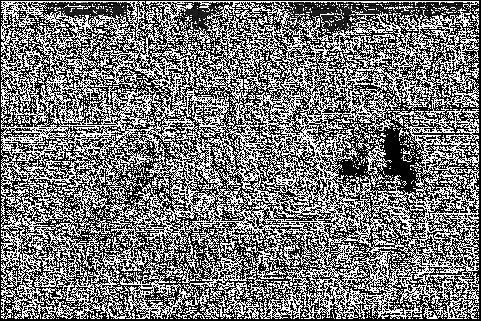

In [29]:
grsy = Gray.(predictHR)